In [12]:
import numpy as np
import os
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [8]:
class LogisticRegression:
    def __init__(self):
        pass

    def fit(self, X, Y, V=None, K=None, D=50, lr=1e-1, mu=0.99, batch_sz=100, epochs=6):
        if V is None:
            V = len(set(X))
        if K is None:
            K = len(set(Y))
        N = len(X)

        W = np.random.randn(V, K) / np.sqrt(V + K)
        b = np.zeros(K)
        self.W = theano.shared(W)
        self.b = theano.shared(b)
        self.params = [self.W, self.b]

        thX = T.ivector('X')
        thY = T.ivector('Y')

        py_x = T.nnet.softmax(self.W[thX] + self.b)
        prediction = T.argmax(py_x, axis=1)

        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        self.cost_predict_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            allow_input_downcast=True,
        )

        updates = [
            (p, p + mu*dp - lr*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - lr*g) for dp, g in zip(dparams, grads)
        ]
        train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            updates=updates,
            allow_input_downcast=True
        )

        costs = []
        n_batches = N // batch_sz
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            print("epoch:", i)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]

                c, p = train_op(Xbatch, Ybatch)
                costs.append(c)
                if j % 200 == 0:
                    print(
                        "i:", i, "j:", j,
                        "n_batches:", n_batches,
                        "cost:", c,
                        "error:", np.mean(p != Ybatch)
                    )
        plt.plot(costs)
        plt.show()

    def score(self, X, Y):
        _, p = self.cost_predict_op(X, Y)
        return np.mean(p == Y)

    def f1_score(self, X, Y):
        _, p = self.cost_predict_op(X, Y)
        return f1_score(Y, p, average=None).mean()
         

In [9]:
def get_data():
    word2idx={}
    tag2idx={}
    word_idx=0
    tag_idx=0
    Xtrain=[]
    Ytrain=[]
    Xtest=[]
    Ytest=[]
    currentX=[]
    currentY=[]

    for line in open('chunking/train.txt'):
        line = line.rstrip()
        if line:
            word,tag,_=line.split()
            if word not in word2idx:
                word2idx[word]=word_idx
                word_idx+=1
            currentX.append(word2idx[word])
            if tag not in tag2idx:
                tag2idx[tag]=tag_idx
                tag_idx+=1
            currentY.append(tag2idx[tag])
    Xtrain=currentX
    Ytrain=currentY

    currentX=[]
    currentY=[]
    for line in open('chunking/test.txt'):
        line = line.rstrip()
        if line:
            word,tag,_=line.split()
            if word in word2idx:
                currentX.append(word2idx[word])
            else:
                currentX.append(word_idx)
            currentY.append(tag2idx[tag])
    Xtest=currentX
    Ytest=currentY
    return np.array(Xtrain),np.array(Ytrain),np.array(Xtest),np.array(Ytest),word2idx

In [10]:
Xtrain,Ytrain,Xtest,Ytest,word2idx = get_data()
N=len(Xtrain)
V=len(word2idx)+1
print("vocabulary size:", V)

vocabulary size: 19123


epoch: 0
i: 0 j: 0 n_batches: 2117 cost: 3.783502555867195 error: 0.99
i: 0 j: 200 n_batches: 2117 cost: 1.5928960367374336 error: 0.5
i: 0 j: 400 n_batches: 2117 cost: 1.3018383607257815 error: 0.4
i: 0 j: 600 n_batches: 2117 cost: 1.0872556347301967 error: 0.26
i: 0 j: 800 n_batches: 2117 cost: 0.9547591456247437 error: 0.24
i: 0 j: 1000 n_batches: 2117 cost: 0.8028865512920147 error: 0.21
i: 0 j: 1200 n_batches: 2117 cost: 0.8415253461931139 error: 0.27
i: 0 j: 1400 n_batches: 2117 cost: 0.8823538489560212 error: 0.22
i: 0 j: 1600 n_batches: 2117 cost: 0.7311465190236924 error: 0.21
i: 0 j: 1800 n_batches: 2117 cost: 0.6853174453172732 error: 0.14
i: 0 j: 2000 n_batches: 2117 cost: 0.6599716908656879 error: 0.16
epoch: 1
i: 1 j: 0 n_batches: 2117 cost: 0.6852098049875777 error: 0.16
i: 1 j: 200 n_batches: 2117 cost: 0.847576401757883 error: 0.2
i: 1 j: 400 n_batches: 2117 cost: 0.5045762014059914 error: 0.12
i: 1 j: 600 n_batches: 2117 cost: 0.5011153846051317 error: 0.12
i: 1 j: 80

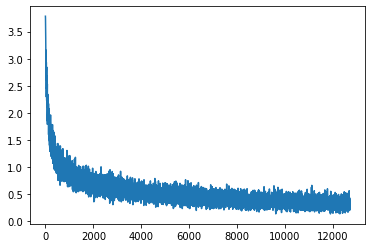

In [21]:
model = LogisticRegression()
model.fit(Xtrain,Ytrain,V=V)

In [22]:
print("training complete")
print("lr train score:", model.score(Xtrain, Ytrain))
print("lr train f1:", model.f1_score(Xtrain, Ytrain))

training complete
lr train score: 0.9313124920298309
lr train f1: 0.8232415779590752


In [16]:
dt=DecisionTreeClassifier()
dt.fit(Xtrain.reshape(N,1),Ytrain)
print("dt train score:", dt.score(Xtrain.reshape(N, 1), Ytrain))
p = dt.predict(Xtrain.reshape(N, 1))
print("dt train f1:", f1_score(Ytrain, p, average=None).mean())

dt train score: 0.9649595941944107
dt train f1: 0.9078586969360977


In [19]:
Ntest = len(Xtest)
print("dt test score:",dt.score(Xtest.reshape(Ntest,1),Ytest))
p=dt.predict(Xtest.reshape(Ntest,1))
print("dt test f1:",f1_score(Ytest,p,average=None).mean())

dt test score: 0.9168372839141355
dt test f1: 0.8717182342896075


In [23]:
print("lr test score:", model.score(Xtest, Ytest))
print("lr test f1:", model.f1_score(Xtest, Ytest))

lr test score: 0.8845853473204297
lr test f1: 0.8206713980073673
